Program Name: Jet_Length_Width_Determiner_v3.py

Date: 6/14/2022

Creator: Sol Samuels

Description: 
 - This program intakes jet related FITS files from ones device, specifically those named in the format \*\*/Group\*0.00_1.00_0.00\*.fits\* , and returns the jet's estimated length and width.
 - The program returns a table for each frequency and its information of year vs. jet dimension
 - NOTE: This is version 3, first DRAFT of this program. Program is subject to be changed.
 
Variable Keywords:
 - cul = "cumulative"
 - slice = refers to rows or columns of fits image pixels
 - vals = "values"
 - norm = "normalized"

In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
import matplotlib.colors as col


In [2]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
        
    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(len(x_vals) / 2)
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
        
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    d3 = np.gradient(smooth_d2)
    smooth_d3 = gaussian_filter1d(d3, 300)
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    
    # for local maxima
    maxima_d2 = argrelextrema(smooth_d2, np.greater)
    # for local minima
    minima_d2 = argrelextrema(smooth_d2, np.less)
    
    
    norm_smooth_d1 = smooth_d1 / np.max(smooth_d1)
    norm_smooth_d2 = smooth_d2 / np.max(smooth_d2)
    norm_smooth_d3 = smooth_d3 / np.max(smooth_d3)
    
    #edited normalized cumulative histogram of data
    #plt.plot(x_vals, norm_cul_vals_edit, color='b', label = "raw")
    #plt.plot(norm_smooth_d1, label='1st derivative', color = "g")
    #plt.plot(norm_smooth_d2, label='2nd derivative', color = "orange")
    #plt.plot(norm_smooth_d3, label='3rd derivative', color = "r")
    #labelcount = 0
    #for i, infl in enumerate(infls, 1):
        #if labelcount == 0:
            #plt.axvline(x=infl, color='k', linestyle='dashed', label="Inflection Points")
        #else:
            #plt.axvline(x=infl, color='k', linestyle='dashed')
        #labelcount += 1
        

    min_lst = []
    max_lst = []
    if len(maxima_d2) > 0:
        for element in maxima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='r', linestyle='dashed')
                    max_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    if len(minima_d2) > 0:
        for element in minima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='y', linestyle='dashed')
                    min_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
                    
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    lobe_dist_kpc = 0.0
    

    max_lst = sorted(max_lst)
    min_lst = sorted(min_lst)
    
    if (len(max_lst) + len(min_lst)) > 3:
        
        main_max = []
        main_min = []
        for point in max_lst:
            if point > x_vals_med and point < x_vals_Q3:
                main_max.append(point)
        for point in min_lst:
            if point > x_vals_Q1 and point < x_vals_med:
                main_min.append(point)
        
        
  
        slice_vals_edit = []
        flag = False
        for element in slice_vals:
            if flag is True:
                slice_vals_edit.append(element)
            if element != 0 and flag is False:
                flag = True
                slice_vals_edit.append(element)

        for i in range(max(main_min), min(main_max)):
            slice_vals_edit[i] = float(0)
            
        lobe_dist = min(main_max) - max(main_min)

        cul_vals = []
        movingsum = 0
        for element in slice_vals_edit:
            movingsum += element
            cul_vals.append(movingsum)

        #Normalizes the Cumulative Values and creates list
        max_val = cul_vals[-1]
        norm_cul_vals = []
        norm = 0
        for element in cul_vals:
            norm = element / max_val
            norm_cul_vals.append(norm)

        #Edits the Normalizes Values to Exclude zeros and repeating terms
        final_reached = False
        norm_cul_vals_edit = []
        for element in norm_cul_vals:
            if element != 0 and final_reached is False:
                norm_cul_vals_edit.append(element)
            if element == 1:
                final_reached = True

    
        #Determines and prints length of jet in pixels. Estimates to 0.98
        pixel_count = 0
        for element in norm_cul_vals_edit:
            if element >= 0.02 and element <= 0.98:
                pixel_count += 1
        
        #Converts pixel size to cm and prints
        jet_size_cm = pixel_size * pixel_count
        
        #Converts cm size to kpc and prints
        jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
        
        lobe_dist_cm = lobe_dist * pixel_size
        lobe_dist_kpc = round((lobe_dist_cm * 3.24077928967e-19) / 1e3, 4)

    
    return lobe_dist_kpc
    


In [3]:
def progress(file_count, total_files):
    print("\tFiles Completed: {}/{}".format(file_count, total_files), end="\r") 
    time.sleep(1)


LOBE SEPARATION TIME FINDER
____________________________________________________________________________________________________


TRYING L430 rc30
		File 1/9: 1.0 Myr


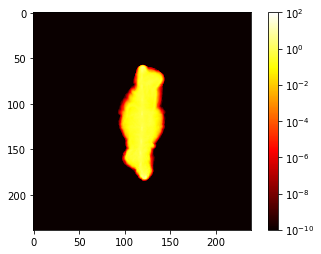

		File 2/9: 2.0 Myr


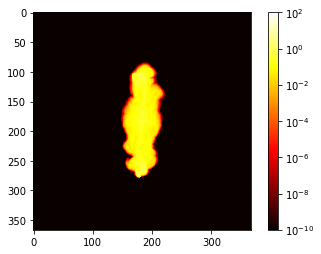

		File 3/9: 4.0 Myr


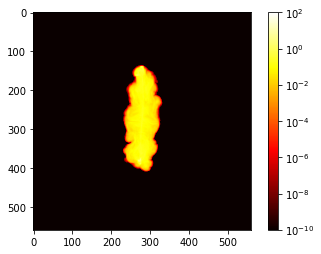

		File 4/9: 8.0 Myr


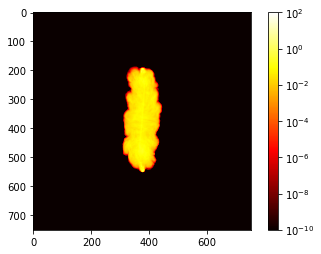

		File 5/9: 16.0 Myr


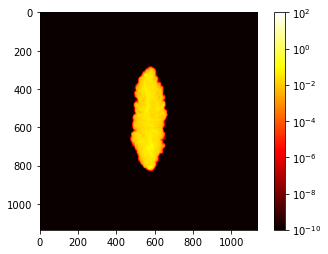

		File 6/9: 32.0 Myr


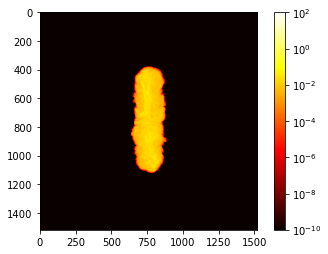

		File 7/9: 64.0 Myr


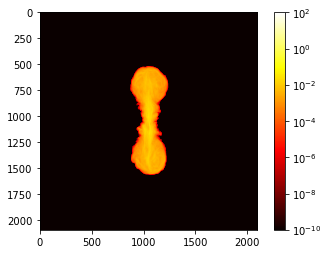

		File 8/9: 127.6 Myr


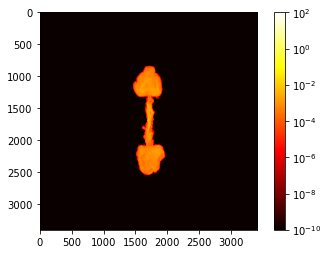


TRYING L438 rc30
		File 1/11: 1.0 Myr


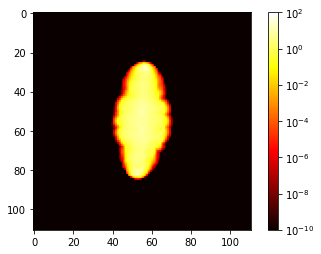

		File 2/11: 2.0 Myr


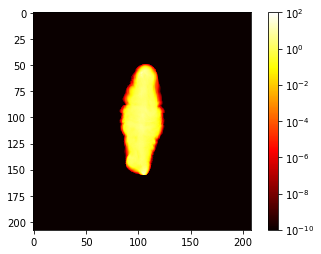

		File 3/11: 4.0 Myr


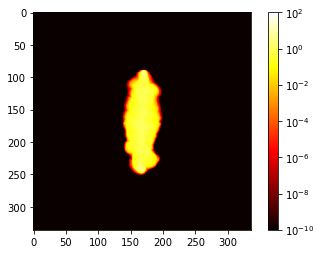

		File 4/11: 5.2 Myr


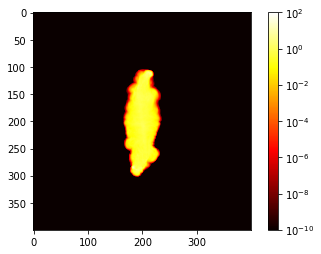

		File 5/11: 17.1 Myr


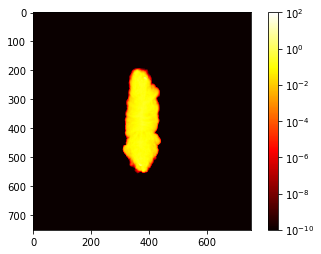

		File 6/11: 32.0 Myr


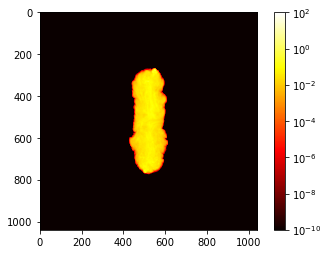

		File 7/11: 64.0 Myr


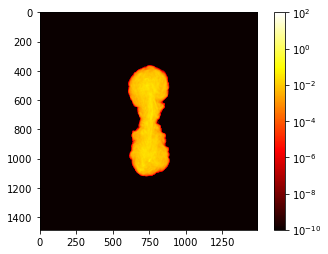

		File 8/11: 128.0 Myr


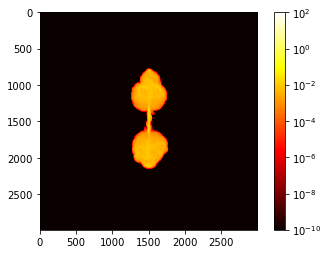


TRYING L446 rc3
		File 1/11: 1.0 Myr


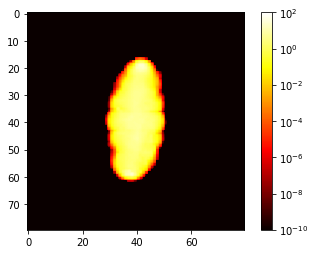

		File 2/11: 2.0 Myr


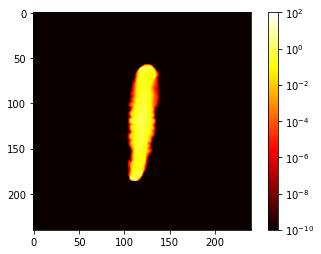

		File 3/11: 4.0 Myr


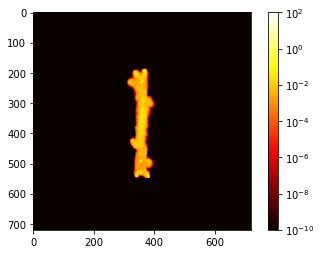

		File 4/11: 8.0 Myr


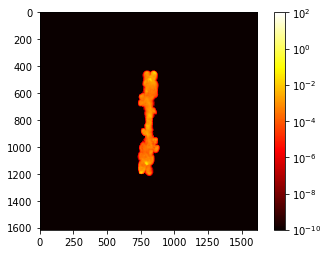

		File 5/11: 13.1 Myr


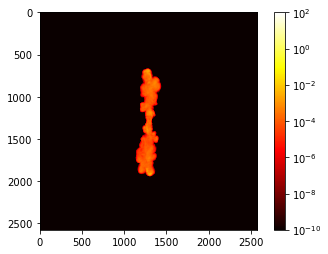


TRYING L446 rc10
		File 1/11: 1.0 Myr


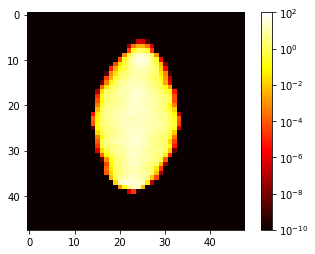

		File 2/11: 2.0 Myr


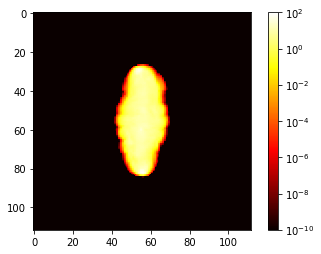

		File 3/11: 4.0 Myr


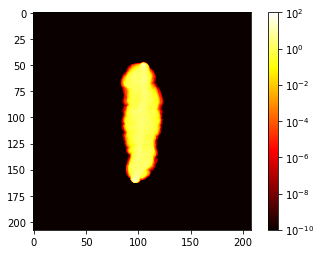

		File 4/11: 8.0 Myr


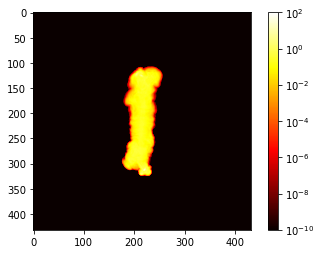

		File 5/11: 16.0 Myr


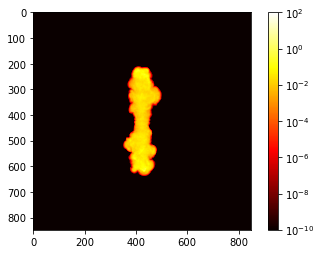

		File 6/11: 32.0 Myr


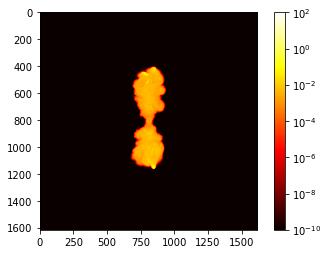

		File 7/11: 64.0 Myr


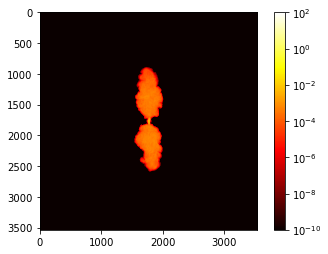


TRYING L446 rc30
		File 1/11: 1.0 Myr


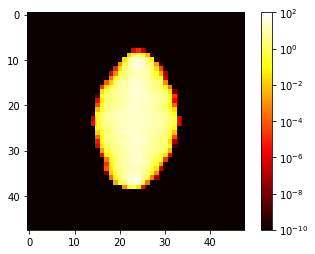

		File 2/11: 2.0 Myr


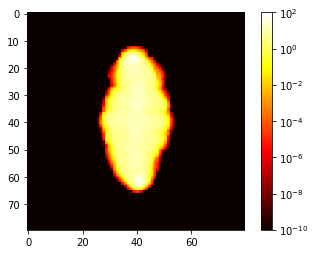

		File 3/11: 4.0 Myr


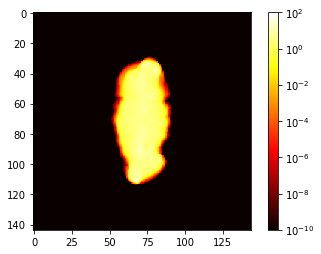

		File 4/11: 8.0 Myr


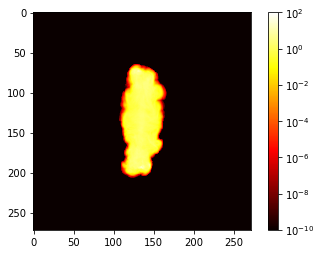

		File 5/11: 16.0 Myr


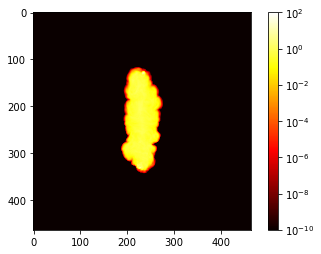

		File 6/11: 32.0 Myr


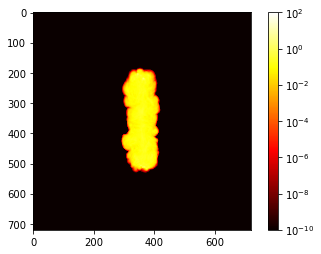

		File 7/11: 64.0 Myr


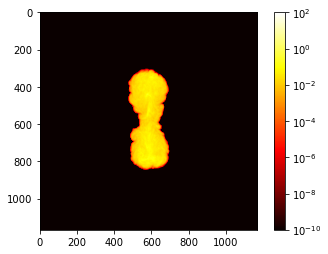

		File 8/11: 121.2 Myr


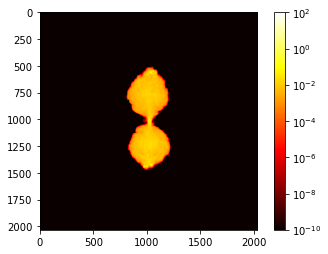

		File 9/11: 256.1 Myr


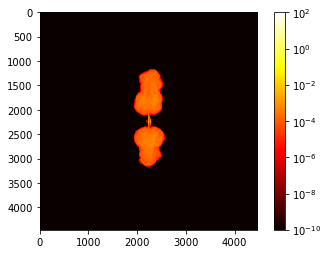


TRYING L446 rc100
		File 1/11: 1.0 Myr


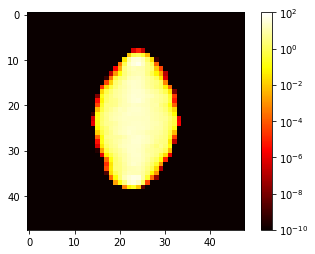

		File 2/11: 2.0 Myr


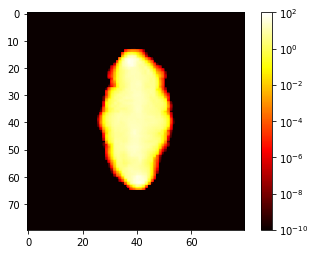

		File 3/11: 4.0 Myr


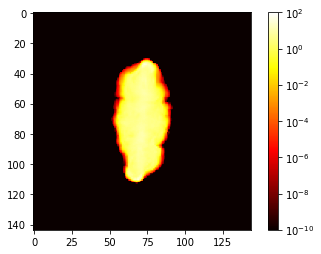

		File 4/11: 8.0 Myr


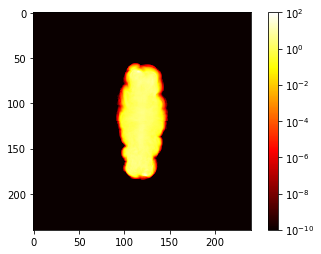

		File 5/11: 16.0 Myr


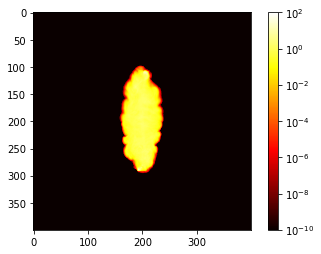

		File 6/11: 32.0 Myr


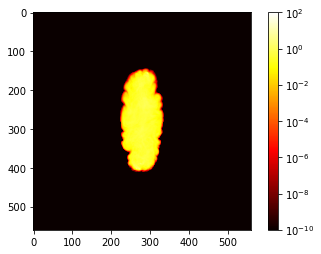

		File 7/11: 64.0 Myr


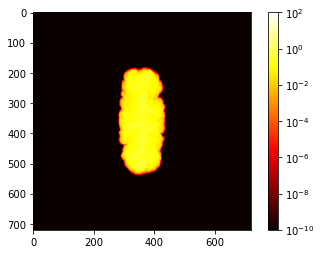

		File 8/11: 128.0 Myr


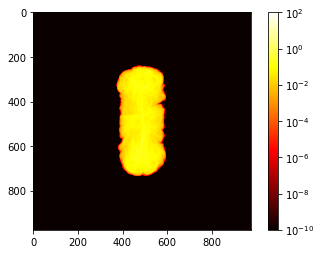

		File 9/11: 256.0 Myr


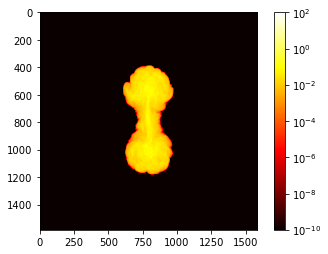

		File 10/11: 512.1 Myr


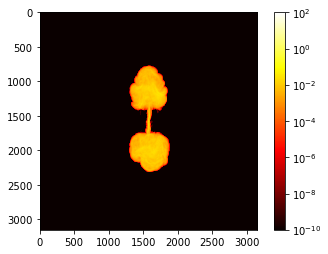



 MASTER LIST:
              0         1                         2             3  \
0  Jet Strength  rc Value  Pre-Lobe Separation(Myr)  File Index 1   
1          L430      rc30                      64.0          3200   
2          L438      rc30                      64.0          1280   
3          L446       rc3                       8.0          0080   
4          L446      rc10                      32.0          0320   
5          L446      rc30                     121.2          1212   
6          L446     rc100                     256.0          2560   

                           4             5  
0  Post-Lobe Separation(Myr)  File Index 2  
1                      127.6          3518  
2                      128.0          2560  
3                       13.1          0131  
4                       64.0          0640  
5                      256.1          2570  
6                      512.1          5132  


In [12]:
#Main Calling Block of Code

print("\nLOBE SEPARATION TIME FINDER")
print("{}\n".format("_"*100))

stren_lst = [430, 438, 446]
rc_lst = [3, 10, 30, 100]
sep_data = np.array([[ "Jet Strength", "rc Value", "Pre-Lobe Separation(Myr)", "File Index 1", "Post-Lobe Separation(Myr)", "File Index 2"]])

for strength in stren_lst:
    for rc in rc_lst:
        
        path = '**/Group_L'+str(strength)+'_rc'+str(rc)+'_*nu=30.0*0.00_1.00_0.00*Myr.fits*'

        # Determines if there are any files in device
        total_files = len(glob.glob(path, recursive=True))

        if total_files > 0:

            print("\nTRYING L{} rc{}".format(strength, rc))
            file_count = 0
            #progress(file_count, total_files)
            
            
            prev_time = 0
            lobe_found = False

            for file in sorted(glob.glob(path, recursive=True)):

                file_count += 1

                try:
                    fits_image_hdul = fits.open(file)
                    
                    image_data = fits.getdata(file, ext=0)
                    hdu = fits.open(file)[0]

                    fits_image_hdul = fits.open(file)

                    #Displays FITS Image title, time index, and pixel size
                    sim_title = fits_image_hdul[0].header['OBJECT']
                    nu_value = int(sim_title[-7:-4])
                    sim_time = fits_image_hdul[0].header['TIME']
                    sim_time = round(float(sim_time[:-4]), 1)
                    pixel = fits_image_hdul[0].header['CDELT1']
                    pixel_size = float(pixel[:-3])
                    
                    for i in range(image_data.shape[0]):
                        for j in range(image_data.shape[1]):
                            if image_data[i, j] == 0:
                                image_data[i, j] = 1e-12
                                
                    print("\t\tFile {}/{}: {} Myr".format(file_count, total_files, sim_time))
            
                    plt.figure()
                    plt.imshow(image_data, cmap='hot', norm=col.LogNorm())
                    plt.clim(10e-11, 1e2) 
                    plt.colorbar() 
                    plt.show()

                    #Difines Data From FITS image and records image dimensions
                    data =  fits_image_hdul[0].data
                    length = len(data[0])
                    width = len(data)
                    
                    count4 = 0
                    index_code = ""
                    for character in file:
                        try:
                            number = int(character)
                            count4 += 1
                            index_code += str(number)
                        except ValueError:
                            count4 = 0
                            index_code = ""
                        
                        if count4 == 4:
                            break

                            
                    
                    #Calls jet_length function
                    lobe_dist_kpc = jet_length(data, pixel_size)
                    
                    if lobe_dist_kpc > 0 and prev_lobe == 0 and lobe_found is False:
                        pre_lob_sep = prev_time
                        post_lob_sep = sim_time
                        
                        file_data = np.array([ "L{}".format(strength), "rc{}".format(rc), pre_lob_sep, prev_index_code, post_lob_sep, index_code])
                        sep_data = np.vstack([sep_data, file_data])
                        
                        lobe_found = True
                        break

                    #progress(file_count, total_files)
                    
                    prev_lobe = lobe_dist_kpc
                    prev_time = sim_time
                    prev_index_code = index_code

                except OSError:
                    print("Error with file: {}".format(file))
                    print("Empty or corrupt FITS file")
                    
            if lobe_found is False:
                file_data = np.array([index_code, "L{}".format(strength), "rc{}".format(rc), 0, 0])
                sep_data = np.vstack([sep_data, file_data])

print("\n\n MASTER LIST:")
data_table = pd.DataFrame(sep_data)


print(data_table)
#with open("corrected_data_table_{}MHz.npy".format(str(value)), "wb") as open_file:
    #np.save(open_file, jet_dim_data)


In [14]:
print("\n\n MASTER LIST:")
data_table = pd.DataFrame(sep_data)


print(data_table)

file_name = 'Lobe_Separation_Data.xlsx'
  
# saving the excel
data_table.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')



 MASTER LIST:
              0         1                         2             3  \
0  Jet Strength  rc Value  Pre-Lobe Separation(Myr)  File Index 1   
1          L430      rc30                      64.0          3200   
2          L438      rc30                      64.0          1280   
3          L446       rc3                       8.0          0080   
4          L446      rc10                      32.0          0320   
5          L446      rc30                     121.2          1212   
6          L446     rc100                     256.0          2560   

                           4             5  
0  Post-Lobe Separation(Myr)  File Index 2  
1                      127.6          3518  
2                      128.0          2560  
3                       13.1          0131  
4                       64.0          0640  
5                      256.1          2570  
6                      512.1          5132  
DataFrame is written to Excel File successfully.


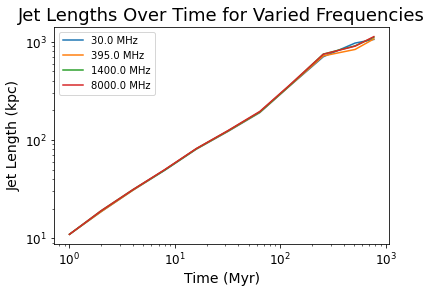

<Figure size 432x288 with 0 Axes>

In [6]:
nu2 = [30.0, 395.0, 1400.0, 8000.0]

for value in nu2:
    try:
        with open("corrected_data_table_{}MHz.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_len_vals = []

            for i in range(1, 12):
                time_vals.append(float(current_freq[i, 0]))
                jet_len_vals.append(float(current_freq[i, 1]))
            
            plt.plot(time_vals, jet_len_vals, label="{} MHz".format(str(value)))
        
    except:
        p = 0
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Length (kpc)", fontsize=14)
plt.title("Jet Lengths Over Time for Varied Frequencies", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.show()
plt.savefig('Jet_Lengths_vs_Time.png')

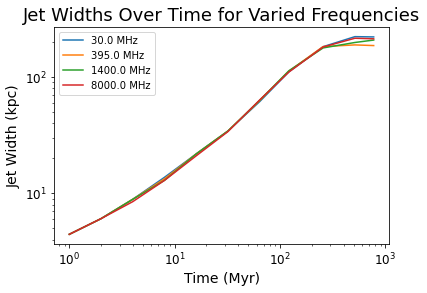

<Figure size 432x288 with 0 Axes>

In [7]:
for value in nu2:
    try:
        with open("corrected_data_table_{}MHz.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_wid_vals = []

            for i in range(1, 12):
                time_vals.append(float(current_freq[i, 0]))
                jet_wid_vals.append(float(current_freq[i, 2]))
            
            plt.plot(time_vals, jet_wid_vals, label="{} MHz".format(str(value)))
        
    except:
        p = 0

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Width (kpc)", fontsize=14)
plt.title("Jet Widths Over Time for Varied Frequencies", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.show()
plt.savefig('Jet_Widths_vs_Time.png')

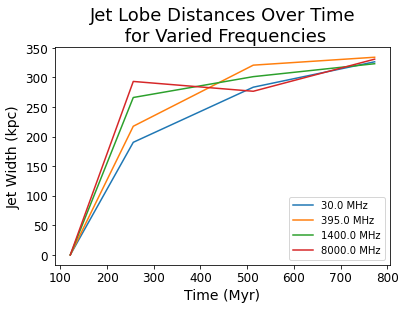

<Figure size 432x288 with 0 Axes>

In [8]:
for value in nu2:
    try:
        with open("corrected_data_table_{}MHz.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_lobe_vals = []

            for i in range(8, 12):
                time_vals.append(float(current_freq[i, 0]))
                jet_lobe_vals.append(float(current_freq[i, 3]))
            
            plt.plot(time_vals, jet_lobe_vals, label="{} MHz".format(str(value)))
        
    except:
        p = 0


plt.xlabel("Time (Myr)", fontsize=14)
plt.ylabel("Jet Width (kpc)", fontsize=14)
plt.title("Jet Lobe Distances Over Time\n for Varied Frequencies", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", prop={'size': 10})
plt.show()
plt.savefig('Lobe_Dist_vs_Time.png')